In [3]:
# Imports
import torch as tc 
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import os, sys, cv2
from torch.cuda.amp import autocast
import matplotlib.pyplot as plt
import albumentations as A
import segmentation_models_pytorch as smp
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from glob import glob
import _general
from sklearn.model_selection import train_test_split

In [4]:
# Config File
p_augm = 0.5

class CFG:
    target_size = 1
    model_name = 'Unet'
    backbone = 'resnext50_32x4d'
    in_chans = 1
    image_size = 512
    input_size = 512
    train_batch_size = 1
    valid_batch_size = 1
    epochs = 25
    lr = 6e-5
    chopping_percentile = 1e-3

    valid_id = 1
    rotate_p = 0.02

    train_aug_list = [
        A.Rotate(limit=270, p= rotate_p),
        A.RandomScale(scale_limit=(0.8, 1.25), interpolation=cv2.INTER_CUBIC, p=p_augm),
        A.RandomCrop(input_size, input_size, p=1),
        A.RandomGamma(p=p_augm*2/3),
        A.RandomBrightnessContrast(p=p_augm),
        A.GaussianBlur(p=p_augm),
        A.MotionBlur(p=p_augm),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=p_augm),
        ToTensorV2(transpose_mask=True),
    ]

    train_aug = A.Compose(train_aug_list)
    valid_aug_list = [
        ToTensorV2(transpose_mask=True),
    ]
    valid_aug_list = A.Compose(valid_aug_list)



In [5]:
# Model
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.model = smp.Unet(
            encoder_name=CFG.backbone,
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
    
    def forward(self, image):
        output = self.model(image)
        return output[:,0]
    

def build_model(weight="imagenet"):
    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

In [7]:
# Grab Data
base_path = '/root/data/train/'
datasets = ['kidney_1_dense/', 'kidney_2/', 'kidney_3_sparse/']
image_loader = _general.ImageGrabber(base_path, datasets)
image_loader.load()
image_files = image_loader.image_files
label_files = image_loader.label_files

# DataLoaders
# slice some middle 10 elements of each list
#image_files = image_files[1500:1700]
#label_files = label_files[1500:1700]

# Train Test Split
train_image_files, val_image_files, train_mask_files, val_mask_files = train_test_split(image_files, label_files, test_size=0.2, random_state=42)

# Create Train/Test Datasets
train_dataset = _general.CustomDataset(train_image_files, train_mask_files, augmentation_transforms=None)
val_dataset = _general.CustomDataset(val_image_files, val_mask_files, augmentation_transforms=None)

# Dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

In [8]:
# dice coefficient
def dice_coef(y_pred:tc.Tensor,y_true:tc.Tensor, thr=0.5, dim=(-1,-2), epsilon=0.001):
    y_pred=y_pred.sigmoid()
    y_true = y_true.to(tc.float32)
    y_pred = (y_pred>thr).to(tc.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean()
    return dice

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = inputs.sigmoid()   
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

In [9]:
tc.backends.cudnn.enabled = True
tc.backends.cudnn.benchmark = True 

model=build_model()
model=DataParallel(model)

loss_fc=DiceLoss()
optimizer=tc.optim.Adam(model.parameters(),lr=CFG.lr)
scaler=tc.cuda.amp.GradScaler()
scheduler = tc.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=CFG.lr, steps_per_epoch=len(train_dataloader), epochs=CFG.epochs+1, pct_start=0.1)

for epoch in range(CFG.epochs):
    model.train()
    time=tqdm(range(len(train_dataloader)))
    losss = 0
    scores = 0
    for i,(x,y) in enumerate(train_dataloader):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        #x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        #x=add_noise(x,mad_randn_rate=0.5,x_already_normed=True)

        with autocast():
            pred=model(x)
            loss=loss_fc(pred,y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        scheduler.step()
        score=dice_coef(pred.detach(),y)
        losss=(losss*i+loss.item())/(i+1)
        scores=(scores*i+score.item())/(i+1)
        time.set_description(f"epoch:{epoch},loss:{losss:.4f},score:{scores:.4f},lr{optimizer.param_groups[0]['lr']:.4e}")
        time.update()
        del loss,pred
    time.close()

    model.eval()
    time=tqdm(range(len(val_dataloader)))
    val_losss = 0
    val_scores = 0
    for i,(x,y) in enumerate(val_dataloader):
        x=x.cuda().to(tc.float32)
        y=y.cuda().to(tc.float32)
        #x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)

        with autocast():
            with tc.no_grad():
                pred=model(x)
                loss=loss_fc(pred,y)
        score=dice_coef(pred.detach(),y)
        val_losss=(val_losss*i+loss.item())/(i+1)
        val_scores=(val_scores*i+score)/(i+1)
        time.set_description(f"val-->loss:{val_losss:.4f},score:{val_scores:.4f}")
        time.update()

    time.close()
tc.save(model.module.state_dict(),f"./{CFG.backbone}_{epoch}_loss{losss:.2f}_score{scores:.2f}_val_loss{val_losss:.2f}_val_score{val_scores:.2f}_midd_rot002.pt")

time.close()
    

model_name Unet
backbone resnext50_32x4d


epoch:0,loss:0.9934,score:0.0078,lr2.4000e-06:   0%|          | 1/4424 [00:01<2:05:17,  1.70s/it]

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 9.77 GiB of which 7.06 MiB is free. Process 3847232 has 354.00 MiB memory in use. Process 3871153 has 8.33 GiB memory in use. Process 3876800 has 1.08 GiB memory in use. Of the allocated memory 807.71 MiB is allocated by PyTorch, and 2.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [11]:
from torchvision.utils import save_image

pred = model(x)
display = save_image(pred,"output.png")

In [20]:
# remove first dimensions from x
x_fix = x[0].squeeze(0)

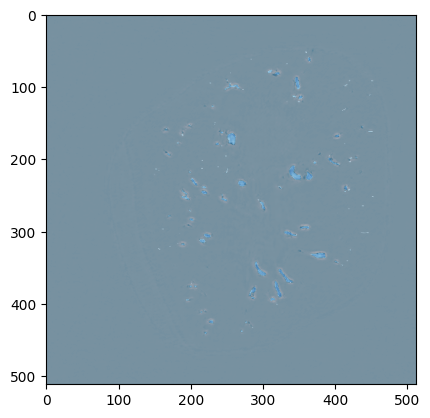

In [40]:
plt.imshow(pred[0].cpu().detach().numpy(), cmap='Blues')
#plt.imshow(x_fix.cpu().detach().numpy(), cmap='gray', alpha=0.3)
plt.imshow(y[0].cpu().detach().numpy(), cmap='gray', alpha=0.3)
plt.show()

In [9]:
len(pred)

1